In [2]:
import skimage.measure
from scipy import ndimage
import numpy as np
import math as m
from scipy import misc
import scipy.stats as st
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
import cv2
from scipy import ndimage as ndi
from skimage import feature
from sympy.solvers import solve
import pandas as pd
plt.ion()
InteractiveShell.ast_node_interactivity='all'

In [3]:
def displayImage(curImage):
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(111)
    plt.imshow(curImage,cmap='gray')
    plt.tight_layout()
    
def rgb2gray(rgb):
    if len(rgb.shape)<=2:
        return np.array(rgb)
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [4]:
img1=rgb2gray(misc.imread('ght.png'))
img2=rgb2gray(misc.imread('edges-lines-orig.png'))
img3=rgb2gray(misc.imread('mnn4-runway-Ohio.jpg'))
img4=rgb2gray(misc.imread('xbl.png'))
img5=rgb2gray(misc.imread('xm.png'))
img6=rgb2gray(misc.imread('fd.png'))
img7=rgb2gray(misc.imread('cv.png'))
imgs=[img1,img2,img3]

### Problem 1 Affine Image Transformation
##### Problem1.1 Resampling

In [16]:
def getTranslationMetrix(shift=(0,0)):
    m=np.array([
        [1,0,shift[0]],
        [0,1,shift[1]],
        [0,0,1]
    ])
    return m
def getRotateMetrix(theta=0):
    m=np.array([
        [np.cos(theta),-np.sin(theta),0],
        [np.sin(theta),np.cos(theta),0],
        [0,0,1]
    ])
    return m
def getScaleMetrix(scale=(1,1)):
    m=np.array([
        [scale[0],0,0],
        [0,scale[1],0],
        [0,0,1]
    ])
    return m
def getShearMetrix(shear=(0,0)):
    m=np.array([
        [1,shear[1],0],
        [shear[0],1,0],
        [0,0,1]
    ])
    return m
def transformByNN(raw,m):
    h,w=raw.shape
    invM=np.linalg.inv(m)
    new=raw.copy()
    for i in range(h-1,-1,-1):
        for j in range(w-1,-1,-1):
            x_,y_,_=invM.dot([i,j,1]).astype(int)
            try:
                new[i,j]=img1[x_,y_]
            except:
#                 print(i,j,x_,y_)
                x_,y_=x_%h,y_%w
#                 new[x_,y_]=raw[i,j]
                new[i,j]=255
    return new

def compTrans(raw,m,t, sample='nn'):
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(121)
    plt.imshow(raw,cmap='gray')
    plt.title(s='Raw Image')

    new=transformByNN(raw,m) if sample=='nn' else transformByBilinear(raw,m)
    plt.subplot(122)
    plt.imshow(new,cmap='gray')
    plt.title(s=t+' Image')
    plt.tight_layout()
    
def transformByBilinear(raw,m):
    h,w=raw.shape
    invM=np.linalg.inv(m)
    new=raw.copy()
    for i in range(h-2,0,-1):
        for j in range(w-2,0,-1):
            x_,y_,_=invM.dot([i,j,1])
            
            if x_<0 or x_>h or y_<0 or y_> w:
                new[i,j]=255
                continue
            x1,x2,y1,y2=int(x_),int(x_)+1,int(y_),int(y_)+1
#             if 20<i<80 and 30<j<70:
#                 print('for {},{}, the source should be:{},{}'.format(i,j,x_,y_))
#                 print('and the four is {} {} {} {}'.format(x1,x2,y1,y2))
                
            try:
                x_y2=(raw[x2,y2]-raw[x1,y2])*(x_-x1)/(x2-x1)+raw[x1,y2]
                x_y1=(raw[x2,y1]-raw[x1,y1])*(x_-x1)/(x2-x1)+raw[x1,y1]

                x_y_=(x_y2-x_y1)*(y_-y1)/(y2-y1)+x_y1
                new[i,j]=x_y_
            except:
                new[i,j]=255
    return new

    

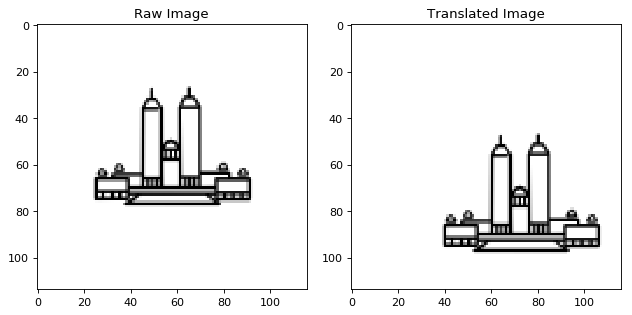

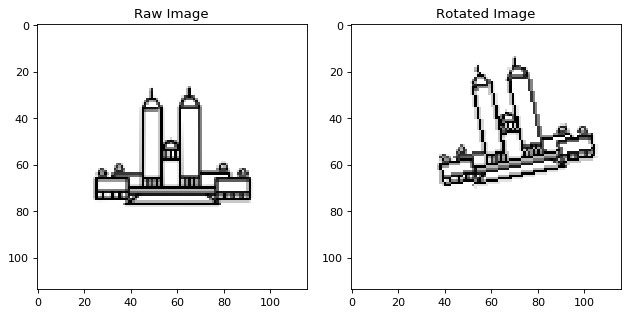

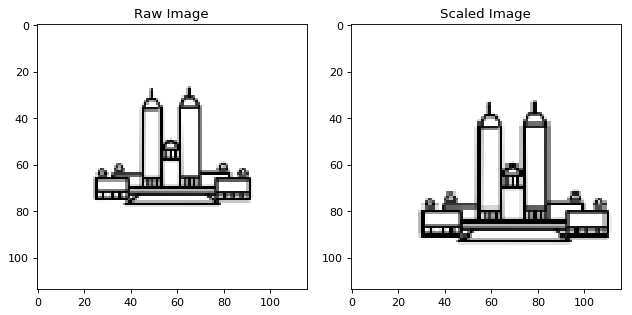

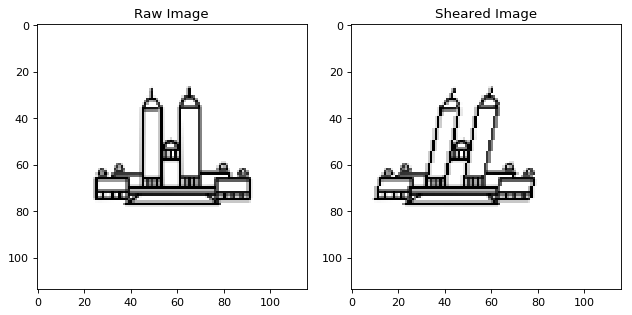

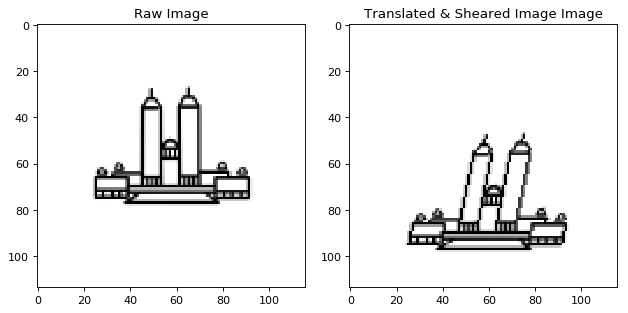

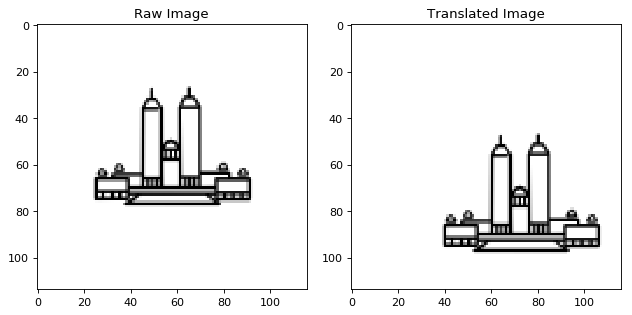

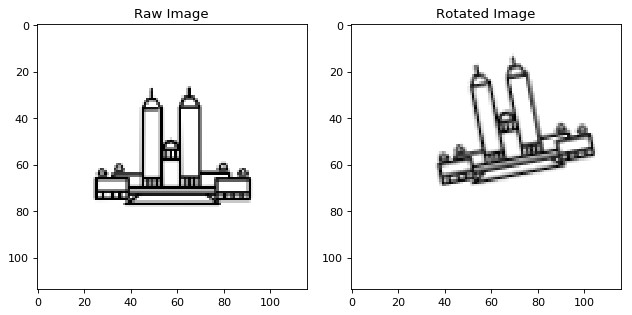

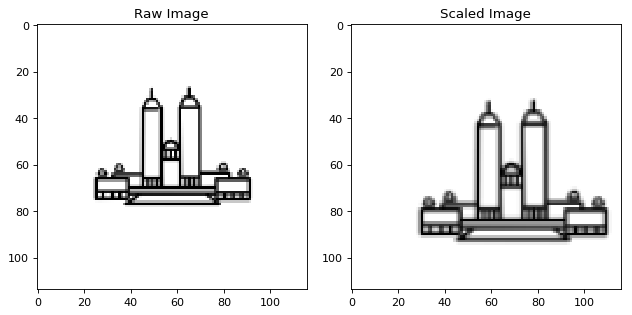

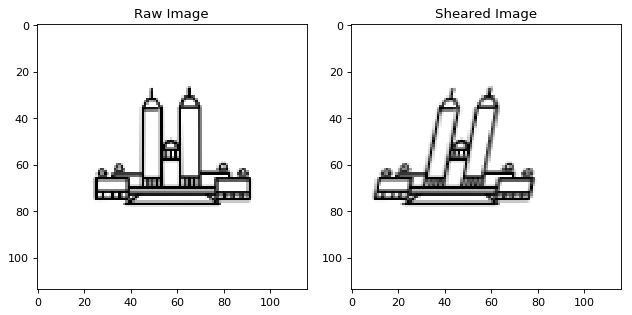

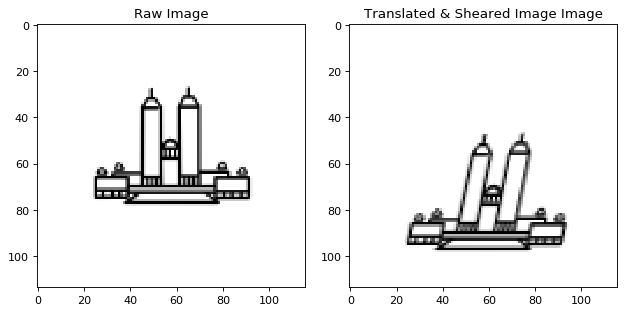

In [17]:
compTrans(img1,getTranslationMetrix((20,15)),t='Translated')
compTrans(img1,getRotateMetrix(theta=np.pi/16),t='Rotated')
compTrans(img1,getScaleMetrix((1.2,1.2)),t='Scaled')
compTrans(img1,getShearMetrix((-0.2,0)),t='Sheared')
compTrans(img1,getTranslationMetrix((20,15)).dot(getShearMetrix((-0.2,0))),t='Translated & Sheared Image')

compTrans(img1,getTranslationMetrix((20,15)),t='Translated',sample='bn')
compTrans(img1,getRotateMetrix(theta=np.pi/16),t='Rotated',sample='bn')
compTrans(img1,getScaleMetrix((1.2,1.2)),t='Scaled',sample='bn')
compTrans(img1,getShearMetrix((-0.2,0)),t='Sheared',sample='bn')
compTrans(img1,getTranslationMetrix((20,15)).dot(getShearMetrix((-0.2,0))),t='Translated & Sheared Image',sample='bn')

##### Problem1.2 Calculate Affine From Landmarks

**Please Notice: Due to the interactive graphic input relies on the interactive backend, the input of landmarks is done elsewhere in the terminal of my Mac, instead of this very ipython-notebook. The codes are in the next cell, commented. Feel free to copy it to the terminal and hit [Enter] (remember to copy all environment values there before.).**

In [514]:
# clicked=[(66.21697862737287, 96.61374352847469,1), (92.54099296429047, 77.90804858622062), (258.2621133678481, 76.66100225673699,1), (288.3272666932164, 55.46121465551573), (188.42751891676622, 79.15509491570424,1), (217.2456259126509, 57.95530731448292), (329.3437541484136, 76.66100225673699,1), (359.40890747378194, 57.95530731448292), (293.1794105933891, 79.15509491570424,1), (321.9975175892738, 59.202353643966546)]
clicked=[(37.53491304924995, 75.41395592725343), (65.10597371565109, 51.72007566706492), (37.53491304924995, 106.59011416434356), (65.10597371565109, 84.14328023363862), (87.41676622859416, 85.39032656312224), (114.98782689499535, 64.19053896190098), (258.2621133678481, 74.1669095977698), (288.3272666932164, 54.21416832603211), (329.3437541484136, 109.08420682331075), (358.1618611442983, 86.63737289260587)]
# a,b,c,d,e,f=symbols('a b c d e f')

# init_printing(use_unicode=True)
# M = Matrix(((a, b, c,66.21697862737287), (d, e, f,96.61374352847469),(0,0,1,1,1,1,1,1)))
# system = A, b = M[:, :3], M[:, 3:]
# linsolve(system, a, b,c,d,e,f )


(array([[ 65.10597372,  51.72007567,   1.        ],
        [ 65.10597372,  84.14328023,   1.        ],
        [114.98782689,  64.19053896,   1.        ],
        [288.32726669,  54.21416833,   1.        ],
        [358.16186114,  86.63737289,   1.        ]]),
 array([[ 37.53491305,  75.41395593],
        [ 37.53491305, 106.59011416],
        [ 87.41676623,  85.39032656],
        [258.26211337,  74.1669096 ],
        [329.34375415, 109.08420682]]))

/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  app.launch_new_instance()


(array([[ 9.92552731e-01, -5.34027088e-03],
        [ 2.54302344e-02,  1.02826751e+00],
        [-2.87250201e+01,  2.09730777e+01]]),
 array([0.96283321, 5.74439406]),
 3,
 array([5.00594357e+02, 8.27228568e+01, 4.69026832e-01]))

array([[ 9.92552731e-01,  2.54302344e-02, -2.87250201e+01],
       [-5.34027088e-03,  1.02826751e+00,  2.09730777e+01],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

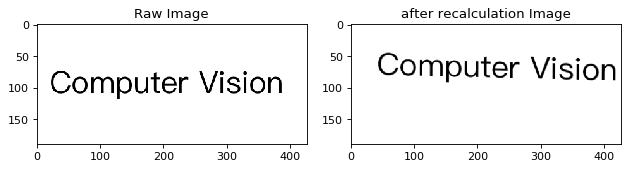

In [518]:
a=[list(clicked[1])+[1],
list(clicked[3])+[1],
list(clicked[5])+[1],
list(clicked[7])+[1],
list(clicked[9])+[1]]

b=[list(clicked[0]),
list(clicked[2]),
list(clicked[4]),
list(clicked[6]),
list(clicked[8])]
A=np.array(a)
B=np.array(b)
A,B
# x = np.linalg.solve(A, B)
x=np.linalg.lstsq(A,B)
x
calculated=np.append(x[0].T,[[0,0,1]],axis=0)
calculated
compTrans(img7,calculated,t='after recalculation',sample='bn')

### Problem 2 Hough Trnasform for Straight Lines
##### Problem2.1  Without Edge Orient

In [5]:
def generateSketch(theta,rous):
    w=len(theta)
    h=rous.max()-rous.min()
    return np.zeros((int(h),w))

def detectLine(img):
    thetaLen=600
    ratio=0.5
    edge= feature.canny(img)
    displayImage(edge)
    thetaStart=-np.pi/2
    thetaStop=thetaStart+np.pi
    
    theta=np.linspace(start=thetaStart,stop=thetaStop,num=thetaLen)
    imgH,imgW=edge.shape
    dots=[(x,imgH-y) for y in range(edge.shape[0]) for x  in range(edge.shape[1]) if edge[y,x]>0]
    rous=[]
    for x,y in dots:
        rous.append(x*np.cos(theta)+y*np.sin(theta))
    rous=np.array(rous)
    rMax,rMin=rous.max(),rous.min()
    sketch=generateSketch(theta,rous)
    
    bottom=rous.min()
    h,w=sketch.shape
    for rou in rous:
        for t in range(len(theta)):
            sketch[(int(rou[t]-bottom-1))][t]+=1
    displayImage(sketch)
#     print("After Conv&Pooling:")
#     sketch=gaussianSmooth(sketch)
#     sketch=maxPooling(sketch,8)
#     sketch=maxPooling(sketch,8)
#     displayImage(sketch)
    threshold=sketch.max()*ratio
    lines=[]
    maxLines=25
    record={'r':[],'t':[],'nvotes':[]}
    while(len(lines)<=maxLines):
        if sketch.max()<threshold:
            break
        _n=sketch.max()
        ind = np.unravel_index(np.argmax(sketch, axis=None), sketch.shape)
#         num_lines-=1
        sketch[ind]=0
        t=np.pi*(ind[1])/sketch.shape[1]+thetaStart
        r=(rMax-rMin)*(ind[0])/sketch.shape[0]+rMin
        lines.append((t,r))
        record['r'].append(r)
        record['t'].append(t)
        record['nvotes'].append(_n)
    d=pd.DataFrame(data=record)
    d.to_csv('25MaximumVotesForLines.csv')
    return (lines,sketch)

/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or
/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


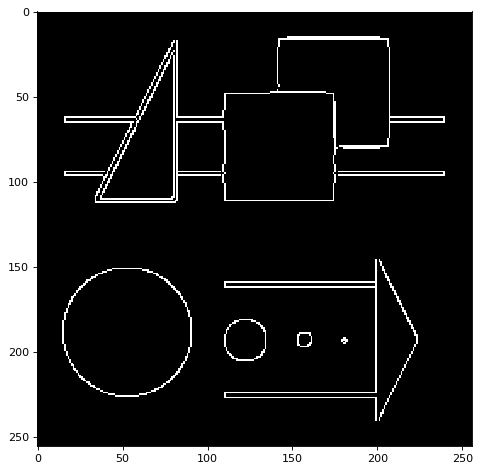

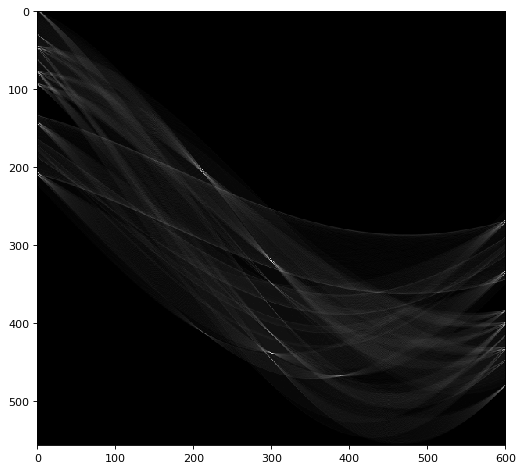

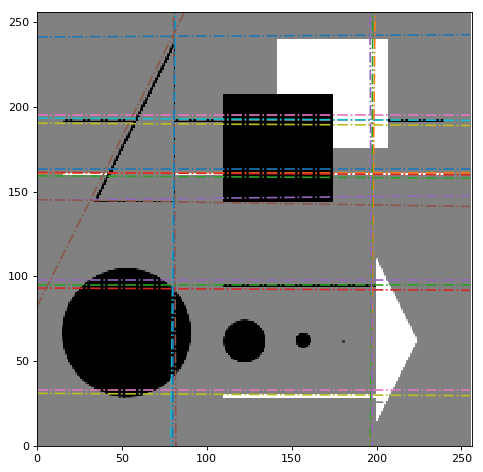

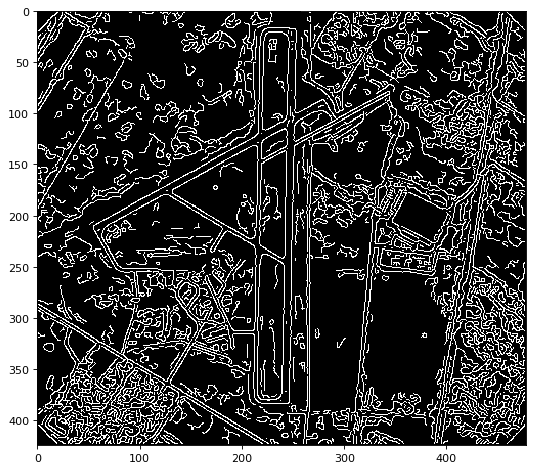

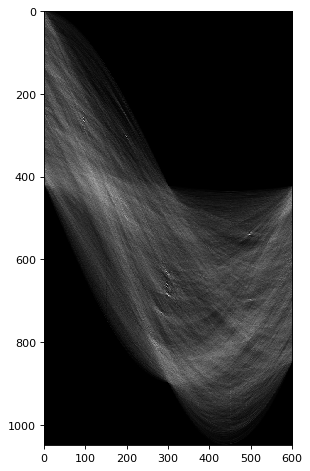

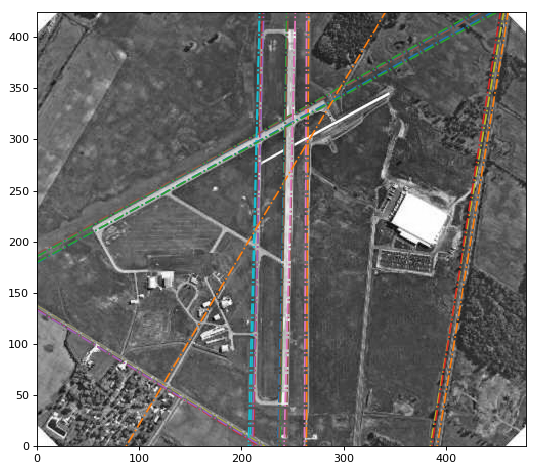

In [6]:
def gkern(kernlen=5, nsig=3):
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def gaussianSmooth(img,k_size=5):
    h,w=img.shape
    kernel=gkern(kernlen=k_size)
    new_img=ndimage.filters.convolve(img,kernel)
    return new_img
def convolve2d(img,size=2):
    kernel=np.ones((size,size))
    return ndimage.filters.convolve(img,kernel)
def maxPooling(img,size=2):
    return skimage.measure.block_reduce(img, (size,size), np.max)
    
def displayLine(img):
    lines,sketch =detectLine(img)
#     print("{} lines detected, with following parameters:".format(len(lines)))
    ab=[]
    for t,r in lines:
        ab.append((-1/np.tan(t),r/np.sin(t)))
#         print("theta:{},rou:{}, calculated line is:[y={}x+{}]".format(t,r,-1/np.tan(t),r/np.sin(t)))
    h,w=img.shape
#     print(h,w)
    x=np.linspace(num=w,start=0,stop=w)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(111)
    plt.axis([0,w,0,h])
    plt.imshow(img[::-1],cmap='gray')

    plt.tight_layout()
    
    for a,b in ab:
        plt.plot(a*x+b,'-.')    
# img2O=np.arctan(derive_x(img2)/derive_y(img2))
displayLine(img2)
displayLine(img3)

In [11]:
d=pd.read_csv('25MaximumVotesForLines.csv')
d

,Unnamed: 0,nvotes,r,t
0,0,255.0,-162.984042,-1.068142
1,1,244.0,264.042065,-0.005236
2,2,240.0,-161.983981,-1.062906
3,3,234.0,212.038886,-0.020944
4,4,225.0,263.042004,0.000000
5,5,223.0,244.040842,-0.020944
6,6,223.0,262.041943,-0.005236
7,7,216.0,265.042126,0.000000
8,8,214.0,117.033077,1.021018
9,9,211.0,209.038702,-0.020944


##### Problem2.2 With Edge Orient

In [8]:
def normalize(img):
    return img/(img.max()-img.min())
def derive_x(img):
    ker=[-1,0,1]
    h,w=img.shape
    new_img=np.copy(img)
    
    for i in range(h):
        for j in range(1,w-1):
            new_img[i][j]=sum(img[i][j-1:j+2]*ker)
#     new_img=255*(new_img-new_img.min())/(new_img.max()-new_img.min())
#     displayImage(new_img)
    return normalize(new_img)

def derive_y(img):
    ker=[-1,0,1]
    h,w=img.shape
    new_img=np.copy(img)
    for i in range(1,h-1):
        for j in range(1,w):
            new_img[i][j]=img[i+1][j]-img[i-1][j]
#     new_img=255*(new_img-new_img.min())/(new_img.max()-new_img.min())
#     displayImage(new_img)
    return normalize(new_img)
def getOrient(img):
    dx=derive_x(img)
    dy=derive_y(img)
    ornt=np.arctan(dx/dy)
    ornt[np.isnan(ornt)]=np.pi/2
    return ornt
def generateSketch(theta,rous):
    w=len(theta)
    h=rous.max()-rous.min()
    return np.zeros((int(h),w))

def detectLineWithOrient(img):
    thetaLen=600
    ratio=0.5
    orient=getOrient(img)
    edge= feature.canny(img)
    displayImage(edge)
    thetaStart=-np.pi/2
    thetaStop=thetaStart+np.pi
    
    theta=np.linspace(start=thetaStart,stop=thetaStop,num=thetaLen)
    imgH,imgW=edge.shape
    dots=[(x,imgH-y) for y in range(edge.shape[0]) for x  in range(edge.shape[1]) if edge[y,x]>0]
    rous=[]
    for x,y in dots:
        rous.append(x*np.cos(theta)+y*np.sin(theta))
    rous=np.array(rous)
    rMax,rMin=rous.max(),rous.min()
    sketch=generateSketch(theta,rous)
    for x,y in dots:
        if edge[y,x]>0:
            o=orient[y,x]
            sketch[:,int(thetaLen*(o+np.pi*0.5)/np.pi)-1]+=1
            
    bottom=rous.min()
    h,w=sketch.shape
    for rou in rous:
        for t in range(len(theta)):
            sketch[(int(rou[t]-bottom-1))][t]+=1
    
            
    displayImage(sketch)
# #     print("After Conv&Pooling:")
#     sketch=gaussianSmooth(sketch)
#     sketch=maxPooling(sketch,8)
# #     sketch=maxPooling(sketch,8)
#     displayImage(sketch)
    threshold=sketch.max()*ratio
    lines=[]
    maxLines=13
    record={'r':[],'t':[],'nvotes':[]}
    while(len(lines)<=maxLines):
        if sketch.max()<threshold:
            break
        _n=sketch.max()
        ind = np.unravel_index(np.argmax(sketch, axis=None), sketch.shape)
#         num_lines-=1
        sketch[ind]=0
        t=np.pi*(ind[1])/sketch.shape[1]+thetaStart
        r=(rMax-rMin)*(ind[0])/sketch.shape[0]+rMin
        lines.append((t,r))
        record['r'].append(r)
        record['t'].append(t)
        record['nvotes'].append(_n)
    d=pd.DataFrame(data=record)
    d.to_csv(str(maxLines)+'MaximumVotesForLines.csv')
    return (lines,sketch)

/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/Users/edwardchor/anaconda3/envs/py36/lib/python3.6/site-packages/scipy/ndimage/measurements.py:431: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  safe = ((np.issubdtype(dt, int) and dt.itemsize <= int_size) or


14 lines detected, with following parameters:


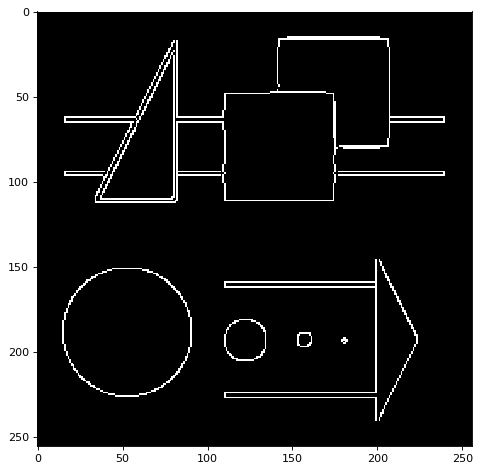

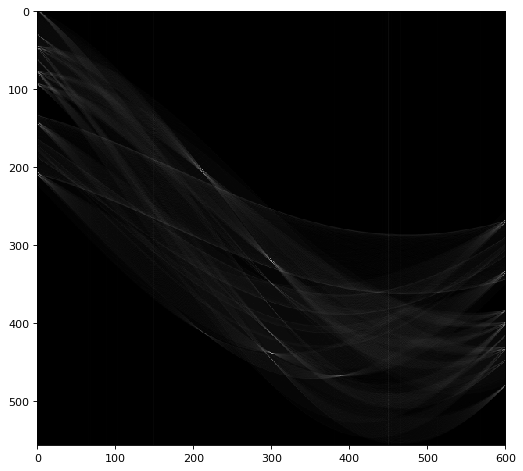

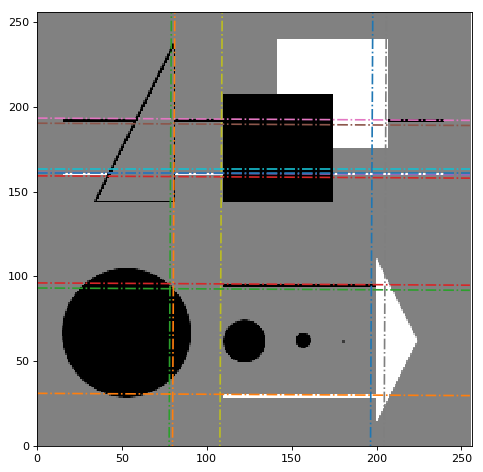

In [9]:
def displayLineWithOrient(img):
    lines,sketch =detectLineWithOrient(img)
    print("{} lines detected, with following parameters:".format(len(lines)))
    ab=[]
    for t,r in lines:
        ab.append((-1/np.tan(t),r/np.sin(t)))
#         print("theta:{},rou:{}, calculated line is:[y={}x+{}]".format(t,r,-1/np.tan(t),r/np.sin(t)))
    h,w=img.shape
#     print(h,w)
    x=np.linspace(num=w,start=0,stop=w)
    plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(111)
    plt.axis([0,w,0,h])
    plt.imshow(img[::-1],cmap='gray')

    plt.tight_layout()
    
    for a,b in ab:
        plt.plot(a*x+b,'-.')  
        
# img2O=np.arctan(derive_x(img2)/derive_y(img2))
displayLineWithOrient(img2)